# Analyse the influence of using any GCM vs W5E5 on the specific MB during calibration time period:

- idea: use the GCM ISIMIP3b data and check how different the specific MB from 2000-2019 is to the W5E5 calibrated specific MB

In [127]:
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
import os

import oggm
from oggm import cfg, utils, workflow, tasks, graphics
from oggm.core import massbalance, climate

cfg.initialize(logging_level='WARNING')
cfg.PARAMS['use_multiprocessing'] = True #True

cfg.PATHS['working_dir'] = '/home/users/lschuster/oggm_w5e5_vs_gcm_gdir'

cfg.PARAMS['border'] = 10
cfg.PARAMS['mp_processes'] = 28
 
base_url = 'https://cluster.klima.uni-bremen.de/~oggm/gdirs/oggm_v1.6/L3-L5_files/elev_bands/w5e5/qc0/pcpwin/match_geod_pergla'
pd_geod = utils.get_geodetic_mb_dataframe()
pd_geod = pd_geod.loc[pd_geod.period == '2000-01-01_2020-01-01']

ssps = ['ssp126', 'ssp585']
gcms = ['ukesm1-0-ll_r1i1p1f2', 'gfdl-esm4_r1i1p1f1',
       'ipsl-cm6a-lr_r1i1p1f1', 'mpi-esm1-2-hr_r1i1p1f1',
       'mri-esm2-0_r1i1p1f1']
climate_type = 'W5E5'
y0 = 2000
y1 = 2019
reload = False
if reload:
    gdirs = workflow.init_glacier_directories(pd_geod[pd_geod.reg == 11].index, from_prepro_level=3, prepro_base_url=base_url)
    for ensemble in gcms:
        for ssp in ssps:
            for correction in [True, False]:
                if correction is True:
                    correct=''
                else:
                    correct='_no_correction'
                workflow.execute_entity_task(oggm.shop.gcm_climate.process_monthly_isimip_data, gdirs, ensemble = ensemble,
                                             ssp = ssp, output_filesuffix=f'{ensemble}_{ssp}{correct}',
                                             apply_bias_correction = correction)
    
    # also do the bias correction on the calibration time period only --> does this help to reduce the differences???
    for ensemble in gcms:
        for ssp in ssps:
            workflow.execute_entity_task(oggm.shop.gcm_climate.process_monthly_isimip_data, gdirs, year_range=(str(y0), str(y1)),
                                                              ssp = ssp, ensemble = ensemble,
                                                              output_filesuffix=f'{ensemble}_{ssp}_bc_{y0}_{y1}',
                                                             apply_bias_correction=True)
else:
    gdirs = workflow.init_glacier_directories(pd_geod[pd_geod.reg == 11].index) #, from_prepro_level=3, prepro_base_url=base_url)

    

2022-10-10 10:21:19: oggm.cfg: Reading default parameters from the OGGM `params.cfg` configuration file.
2022-10-10 10:21:19: oggm.cfg: Multiprocessing switched OFF according to the parameter file.
2022-10-10 10:21:19: oggm.cfg: Multiprocessing: using all available processors (N=32)
2022-10-10 10:21:19: oggm.cfg: Multiprocessing switched ON after user settings.
2022-10-10 10:21:19: oggm.cfg: PARAMS['border'] changed from `40` to `10`.
2022-10-10 10:21:19: oggm.cfg: Multiprocessing: using the requested number of processors (N=28)
2022-10-10 10:21:20: oggm.workflow: Execute entity tasks [GlacierDirectory] on 3927 glaciers


In [169]:
correct

''

In [176]:
                        if correction is True:
                            correct=''
                        elif correction == f'True: yr {y0}--{y1}':
                            print('t')
                            correct = f'_bc_{y0}_{y1}'
                        else:
                            correct='_no_correction'

t


In [175]:
correction

'True: yr 2000--2019'

In [ ]:
            hgts, widths = gdir.get_inversion_flowline_hw()
            mb_mod = massbalance.PastMassBalance(gdir)
            spec_mb_2000_2019_w5e5 = mb_mod.get_specific_mb(heights=hgts, widths=widths,
                                                                          year=np.arange(2000, # yrs_seasonal_mbs[0]
                                                                                         2019 + 1, 1)).mean()
            spec_mb_2000_2019_obs = pd_geod.loc[gdir.rgi_id].dmdtda*1000
            for ensemble in gcms:
                for ssp in ssps:
                    for correction in [f'True: yr {y0}--{y1}']: #[True, False]
                        if correction is True:
                            correct=''
                        elif correction == f'True: yr {y0}--{y1}':
                            correct = f'_bc_{y0}_{y1}'
                        else:
                            correct='_no_correction'
                        mb_mod = massbalance.PastMassBalance(gdir, filename='gcm_data',
                                                             input_filesuffix = f'{ensemble}_{ssp}{correct}')
                        spec_mb_2000_2019_gcm = mb_mod.get_specific_mb(heights=hgts, widths=widths,
                                                                          year=np.arange(2000, # yrs_seasonal_mbs[0]
                                                                                         2019 + 1, 1)).mean()

                        pd_spec_mb_gcm_vs_w5e5.loc[j, 'rgi_id'] = gdir.rgi_id
                        pd_spec_mb_gcm_vs_w5e5.loc[j, 'gcm'] = ensemble
                        pd_spec_mb_gcm_vs_w5e5.loc[j, 'ssp'] = ssp
                        pd_spec_mb_gcm_vs_w5e5.loc[j, 'apply_bias_correction'] = correction
                        pd_spec_mb_gcm_vs_w5e5.loc[j, 'spec_mb_2000_2019_gcm'] = spec_mb_2000_2019_gcm
                        pd_spec_mb_gcm_vs_w5e5.loc[j, 'spec_mb_2000_2019_w5e5'] = spec_mb_2000_2019_w5e5
                        pd_spec_mb_gcm_vs_w5e5.loc[j, 'spec_mb_2000_2019_obs'] = spec_mb_2000_2019_obs
                        j += 1

In [177]:
y0 = 2000
y1 = 2019
load = False
if load:
    pd_spec_mb_gcm_vs_w5e5 = pd.DataFrame(np.NaN, index=np.arange(0, 1000000), #*len(gdirs))),
                                columns=['rgi_id', 'gcm', 'ssp',
                                        'spec_mb_2000_2019_gcm', 'spec_mb_2000_2019_w5e5',
                                         'spec_mb_2000_2019_obs', 'apply_bias_correction'])

    j = 0
    for gdir in gdirs:
        try:
            hgts, widths = gdir.get_inversion_flowline_hw()
            mb_mod = massbalance.PastMassBalance(gdir)
            spec_mb_2000_2019_w5e5 = mb_mod.get_specific_mb(heights=hgts, widths=widths,
                                                                          year=np.arange(2000, # yrs_seasonal_mbs[0]
                                                                                         2019 + 1, 1)).mean()
            spec_mb_2000_2019_obs = pd_geod.loc[gdir.rgi_id].dmdtda*1000
            for ensemble in gcms:
                for ssp in ssps:
                    for correction in [f'True: yr {y0}--{y1}']: #[True, False]
                        if correction is True:
                            correct=''
                        elif correction == f'True: yr {y0}--{y1}':
                            correct = f'_bc_{y0}_{y1}'
                        else:
                            correct='_no_correction'
                        mb_mod = massbalance.PastMassBalance(gdir, filename='gcm_data',
                                                             input_filesuffix = f'{ensemble}_{ssp}{correct}')
                        spec_mb_2000_2019_gcm = mb_mod.get_specific_mb(heights=hgts, widths=widths,
                                                                          year=np.arange(2000, # yrs_seasonal_mbs[0]
                                                                                         2019 + 1, 1)).mean()

                        pd_spec_mb_gcm_vs_w5e5.loc[j, 'rgi_id'] = gdir.rgi_id
                        pd_spec_mb_gcm_vs_w5e5.loc[j, 'gcm'] = ensemble
                        pd_spec_mb_gcm_vs_w5e5.loc[j, 'ssp'] = ssp
                        pd_spec_mb_gcm_vs_w5e5.loc[j, 'apply_bias_correction'] = correction
                        pd_spec_mb_gcm_vs_w5e5.loc[j, 'spec_mb_2000_2019_gcm'] = spec_mb_2000_2019_gcm
                        pd_spec_mb_gcm_vs_w5e5.loc[j, 'spec_mb_2000_2019_w5e5'] = spec_mb_2000_2019_w5e5
                        pd_spec_mb_gcm_vs_w5e5.loc[j, 'spec_mb_2000_2019_obs'] = spec_mb_2000_2019_obs
                        j += 1

        except:
            pass
    pd_spec_mb_gcm_vs_w5e5 = pd_spec_mb_gcm_vs_w5e5.dropna()
    pd_spec_mb_gcm_vs_w5e5['difference_gcm_vs_w5e5'] = pd_spec_mb_gcm_vs_w5e5['spec_mb_2000_2019_gcm'] - pd_spec_mb_gcm_vs_w5e5['spec_mb_2000_2019_obs']
    pd_spec_mb_gcm_vs_w5e5['rel_perc_difference_gcm_vs_w5e5'] = 100 * pd_spec_mb_gcm_vs_w5e5['difference_gcm_vs_w5e5'] / pd_spec_mb_gcm_vs_w5e5['spec_mb_2000_2019_obs']
    pd_spec_mb_gcm_vs_w5e5['ratio_gcm_vs_w5e5'] = pd_spec_mb_gcm_vs_w5e5['spec_mb_2000_2019_gcm'] / pd_spec_mb_gcm_vs_w5e5['spec_mb_2000_2019_obs']
    pd_spec_mb_gcm_vs_w5e5_bc_2000_2019 = pd_spec_mb_gcm_vs_w5e5.copy()
    pd_spec_mb_gcm_vs_w5e5_bc_2000_2019.to_csv(f'alpine_glacier_spec_mb_gcm_vs_w5e5_bc_{y0}_{y1}.csv')
else:
    pd_spec_mb_gcm_vs_w5e5_bc_2000_2019 = pd.read_csv(f'alpine_glacier_spec_mb_gcm_vs_w5e5_bc_{y0}_{y1}.csv', index_col=0)


In [73]:
load = False
if load:
    pd_spec_mb_gcm_vs_w5e5 = pd.DataFrame(np.NaN, index=np.arange(0, 1000000), #*len(gdirs))),
                                columns=['rgi_id', 'gcm', 'ssp',
                                        'spec_mb_2000_2019_gcm', 'spec_mb_2000_2019_w5e5',
                                         'spec_mb_2000_2019_obs', 'apply_bias_correction'])

    j = 0
    for gdir in gdirs:
        try:
            hgts, widths = gdir.get_inversion_flowline_hw()
            mb_mod = massbalance.PastMassBalance(gdir)
            spec_mb_2000_2019_w5e5 = mb_mod.get_specific_mb(heights=hgts, widths=widths,
                                                                          year=np.arange(2000, # yrs_seasonal_mbs[0]
                                                                                         2019 + 1, 1)).mean()
            spec_mb_2000_2019_obs = pd_geod.loc[gdir.rgi_id].dmdtda*1000
            for ensemble in gcms:
                for ssp in ssps:
                    for correction in [True, False]:
                        if correction:
                            correct=''
                        else:
                            correct='_no_correction'
                        mb_mod = massbalance.PastMassBalance(gdir, filename='gcm_data', input_filesuffix = f'{ensemble}_{ssp}{correct}')
                        spec_mb_2000_2019_gcm = mb_mod.get_specific_mb(heights=hgts, widths=widths,
                                                                          year=np.arange(2000, # yrs_seasonal_mbs[0]
                                                                                         2019 + 1, 1)).mean()

                        pd_spec_mb_gcm_vs_w5e5.loc[j, 'rgi_id'] = gdir.rgi_id
                        pd_spec_mb_gcm_vs_w5e5.loc[j, 'gcm'] = ensemble
                        pd_spec_mb_gcm_vs_w5e5.loc[j, 'ssp'] = ssp
                        pd_spec_mb_gcm_vs_w5e5.loc[j, 'apply_bias_correction'] = correction
                        pd_spec_mb_gcm_vs_w5e5.loc[j, 'spec_mb_2000_2019_gcm'] = spec_mb_2000_2019_gcm
                        pd_spec_mb_gcm_vs_w5e5.loc[j, 'spec_mb_2000_2019_w5e5'] = spec_mb_2000_2019_w5e5
                        pd_spec_mb_gcm_vs_w5e5.loc[j, 'spec_mb_2000_2019_obs'] = spec_mb_2000_2019_obs
                        j += 1

        except:
            pass
    pd_spec_mb_gcm_vs_w5e5 = pd_spec_mb_gcm_vs_w5e5.dropna()
    pd_spec_mb_gcm_vs_w5e5['difference_gcm_vs_w5e5'] = pd_spec_mb_gcm_vs_w5e5['spec_mb_2000_2019_gcm'] - pd_spec_mb_gcm_vs_w5e5['spec_mb_2000_2019_obs']
    pd_spec_mb_gcm_vs_w5e5['rel_perc_difference_gcm_vs_w5e5'] = 100 * pd_spec_mb_gcm_vs_w5e5['difference_gcm_vs_w5e5'] / pd_spec_mb_gcm_vs_w5e5['spec_mb_2000_2019_obs']
    pd_spec_mb_gcm_vs_w5e5['ratio_gcm_vs_w5e5'] = pd_spec_mb_gcm_vs_w5e5['spec_mb_2000_2019_gcm'] / pd_spec_mb_gcm_vs_w5e5['spec_mb_2000_2019_obs']

    pd_spec_mb_gcm_vs_w5e5.to_csv('alpine_glacier_spec_mb_gcm_vs_w5e5.csv')
else:
    pd_spec_mb_gcm_vs_w5e5 = pd.read_csv('alpine_glacier_spec_mb_gcm_vs_w5e5.csv', index_col=0)


In [179]:
_pd_spec_mb_gcm_vs_w5e5 = pd.read_csv('alpine_glacier_spec_mb_gcm_vs_w5e5.csv', index_col=0)
_pd_spec_mb_gcm_vs_w5e5_bc_2000_2019 = pd.read_csv(f'alpine_glacier_spec_mb_gcm_vs_w5e5_bc_{y0}_{y1}.csv', index_col=0)
pd_spec_mb_gcm_vs_w5e5 = pd.concat([_pd_spec_mb_gcm_vs_w5e5, _pd_spec_mb_gcm_vs_w5e5_bc_2000_2019])


In [180]:
# remove those glaciers with "0" observed specific MB out of the statistic
rgi_w_0_mb = pd_spec_mb_gcm_vs_w5e5.iloc[np.where(pd_spec_mb_gcm_vs_w5e5['spec_mb_2000_2019_obs'] == 0)].rgi_id.unique()
print(rgi_w_0_mb)
for r in rgi_w_0_mb:
    pd_spec_mb_gcm_vs_w5e5 = pd_spec_mb_gcm_vs_w5e5.iloc[np.where(pd_spec_mb_gcm_vs_w5e5.index!=r)]

['RGI60-11.03778' 'RGI60-11.03818']


In [181]:
# because of calibration, this should be the same:
np.testing.assert_allclose(pd_spec_mb_gcm_vs_w5e5['spec_mb_2000_2019_obs'].values, pd_spec_mb_gcm_vs_w5e5['spec_mb_2000_2019_w5e5'].values, atol=1e-3)
# average differences between applying bias correction or not 
pd_spec_mb_gcm_vs_w5e5.groupby(by='apply_bias_correction').quantile([0.05, 0.25,0.50,0.75, 0.95])

/tmp/ipykernel_1875130/1366677533.py:4: FutureWarning: Dropping invalid columns in DataFrameGroupBy.quantile is deprecated. In a future version, a TypeError will be raised. Before calling .quantile, select only columns which should be valid for the function.
  pd_spec_mb_gcm_vs_w5e5.groupby(by='apply_bias_correction').quantile([0.05, 0.25,0.50,0.75, 0.95])


spec_mb_2000_2019_gcm  spec_mb_2000_2019_w5e5  \
apply_bias_correction                                                       
False                 0.05           -1395.838741           -1.156900e+03   
                      0.25            -893.899883           -7.943000e+02   
                      0.50            -630.625525           -5.963719e+02   
                      0.75            -371.430970           -4.184000e+02   
                      0.95              68.291317           -1.264766e-13   
True                  0.05           -1351.567789           -1.156900e+03   
                      0.25            -852.582931           -7.943000e+02   
                      0.50            -597.043709           -5.963719e+02   
                      0.75            -343.222261           -4.184000e+02   
                      0.95              97.625642           -1.264766e-13   
True: yr 2000--2019   0.05           -1166.958733           -1.156900e+03   
                      0.25            -811.165777           -7.943000e+02   
                      0.50            -617.705575           -5.963719e+02   
                      0.75            -431.358401           -4.184000e+02   
                      0.95              -8.802774           -1.264766e-13   

                            spec_mb_2000_2019_obs  difference_gcm_vs_w5e5  \
apply_bias_correction                                                       
False                 0.05           -1156.900000             -501.315651   
                      0.25            -794.300000             -164.533389   
                      0.50            -596.371893              -15.245944   
                      0.75            -418.400000              122.811305   
                      0.95               0.000000              320.563072   
True                  0.05           -1156.900000             -494.344949   
                      0.25            -794.300000             -129.348306   
                      0.50            -596.371893               17.549061   
                      0.75            -418.400000              152.655583   
                      0.95               0.000000              341.586502   
True: yr 2000--2019   0.05           -1156.900000              -73.725384   
                      0.25            -794.300000              -37.753931   
                      0.50            -596.371893              -15.063724   
                      0.75            -418.400000                8.896489   
                      0.95               0.000000               44.701444   

                            rel_perc_difference_gcm_vs_w5e5  ratio_gcm_vs_w5e5  
apply_bias_correction                                                           
False                 0.05                       -87.099273           0.129007  
                      0.25                       -21.227245           0.787728  
                      0.50                         2.332115           1.023321  
                      0.75                        29.414121           1.294141  
                      0.95                       124.210839           2.242108  
True                  0.05                       -94.705103           0.052949  
                      0.25                       -26.050633           0.739494  
                      0.50                        -2.379314           0.976207  
                      0.75                        22.497070           1.224971  
                      0.95                       113.835016           2.138350  
True: yr 2000--2019   0.05                       -12.439902           0.875601  
                      0.25                        -1.780337           0.982197  
                      0.50                         2.169556           1.021696  
                      0.75                         6.350496           1.063505  
                      0.95                        20.759904           1.207599

In [182]:
pd_spec_mb_gcm_vs_w5e5.loc[pd_spec_mb_gcm_vs_w5e5.apply_bias_correction == False, 'apply_bias_correction'] = 'No: only ISIMIP bc\n(yr 1979-2014)'
pd_spec_mb_gcm_vs_w5e5.loc[pd_spec_mb_gcm_vs_w5e5.apply_bias_correction == True, 'apply_bias_correction'] = 'Yes: yr 1979-2014'
pd_spec_mb_gcm_vs_w5e5.loc[pd_spec_mb_gcm_vs_w5e5.apply_bias_correction == 'True: yr 2000--2019', 'apply_bias_correction'] = 'Yes: yr 2000-2019'

In [160]:
pd_spec_mb_gcm_vs_w5e5.apply_bias_correction.unique()

array(['Yes: yr 1979-2014', 'No: only ISIMIP bc\n(yr 1979-2014)',
       'Yes: yr 2000-2019'], dtype=object)

/home/users/lschuster/.local/lib/python3.10/site-packages/numpy/core/_methods.py:180: RuntimeWarning: invalid value encountered in reduce
  ret = umr_sum(arr, axis, dtype, out, keepdims, where=where)
/home/users/lschuster/.local/lib/python3.10/site-packages/numpy/core/_methods.py:180: RuntimeWarning: invalid value encountered in reduce
  ret = umr_sum(arr, axis, dtype, out, keepdims, where=where)
/home/users/lschuster/.local/lib/python3.10/site-packages/numpy/core/_methods.py:180: RuntimeWarning: invalid value encountered in reduce
  ret = umr_sum(arr, axis, dtype, out, keepdims, where=where)


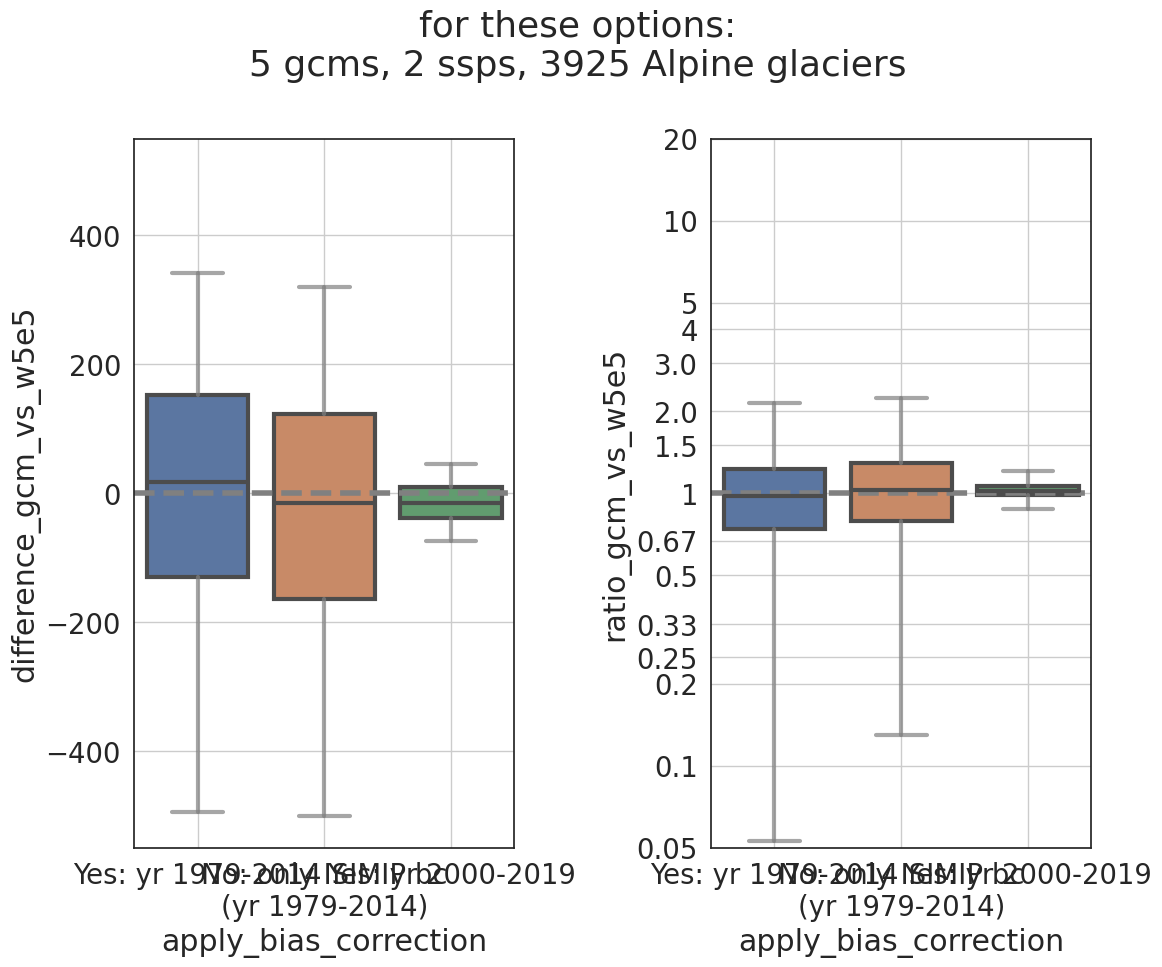

In [183]:
import seaborn as sns
n_glac = len(pd_spec_mb_gcm_vs_w5e5.rgi_id.unique())
sns.set(font_scale=1.8)
sns.set_style('white')
marker = 'o'


fig, axs = plt.subplots(1, 2, sharex=True, #sharey=True,
                            figsize=(12,10)) # 30, 15

plt.suptitle(f'for these options:\n{len(gcms)} gcms, {len(ssps)} ssps, {n_glac} Alpine glaciers')
order = ['Yes: yr 1979-2014', 'No: only ISIMIP bc\n(yr 1979-2014)',
       'Yes: yr 2000-2019']


param = 'difference_gcm_vs_w5e5' #''difference_gcm_vs_w5e5'
g=sns.boxplot(y=param, data=pd_spec_mb_gcm_vs_w5e5, #hue='gcm',
              x='apply_bias_correction',
              order=order,
              fliersize=0, whis = [5,95], 
            linewidth=3,
            saturation=0.7,# aspect=1.6, #order = ['var_an_cycle'],
            capprops={'color':'grey', 'alpha':0.7},
            whiskerprops={'color':'grey', 'alpha':0.7},
              ax = axs[0]
             )
axs[0].grid()
plt.axhline(0, ls='--', lw=4, color='grey')
plt.ylabel(param)
axs[0].axhline(0, ls='--', lw=4, color='grey')

g.set_ylim([-550,550])


ax = axs[1]
param = 'ratio_gcm_vs_w5e5' #''difference_gcm_vs_w5e5'
g=sns.boxplot(y=param, data=pd_spec_mb_gcm_vs_w5e5, #hue='gcm',
              x='apply_bias_correction',
              order=order,
              fliersize=0, whis = [5,95], 
            linewidth=3,
            saturation=0.7,# aspect=1.6, #order = ['var_an_cycle'],
            capprops={'color':'grey', 'alpha':0.7},
            whiskerprops={'color':'grey', 'alpha':0.7},
              ax = ax )
ax.set_yscale("log")
from matplotlib.ticker import ScalarFormatter, NullFormatter
ax.yaxis.set_major_formatter(ScalarFormatter())
ax.yaxis.set_minor_formatter(NullFormatter())
ax.set_ylim([0.05,20])
ax.axhline(1, ls='--', lw=4, color='grey')

ax.set_yticklabels([])
# ERROR
#  ax.set_xticklabels([0.33, 0.5, 0.67, 1,1.5, 2.0, 3.0], labels=[0.33, 0.5, 0.67, 1,1.5, 2.0, 3.0])
ax.set_yticks(ticks=[0.05,0.1,0.2,0.25,0.33, 0.5, 0.67, 1,1.5, 2.0, 3.0,4,5,10,20],
              labels=[0.05, 0.1,0.2,0.25,0.33, 0.5, 0.67, 1,1.5, 2.0, 3.0,4,5,10,20])
ax.grid() #axis='y')
plt.axhline(0, ls='--', lw=4, color='grey')
plt.ylabel(param)

plt.tight_layout()
#g.set_xlabel('surface type distinction')
#g.set_xticklabels(['no', 'yes\n(neg_exp)' , 'yes\n(linear)'])
#g.set_title(calib_type)

In [184]:
gcms_sh = ['ukesm1-0-ll',
 'gfdl-esm4',
 'ipsl-cm6a-lr',
 'mpi-esm1-2',
 'mri-esm2-0']
for j,_ in enumerate(gcms):
    pd_spec_mb_gcm_vs_w5e5.loc[pd_spec_mb_gcm_vs_w5e5.gcm==gcms[j], 'gcm_sh'] = gcms_sh[j]

In [185]:
pd_spec_mb_gcm_vs_w5e5_all = pd_spec_mb_gcm_vs_w5e5.copy()
pd_spec_mb_gcm_vs_w5e5_all['gcm_sh'] = 'all gcms\ntogether'
pd_spec_mb_gcm_vs_w5e5_all = pd.concat([pd_spec_mb_gcm_vs_w5e5, pd_spec_mb_gcm_vs_w5e5_all])

/home/users/lschuster/.local/lib/python3.10/site-packages/numpy/core/_methods.py:180: RuntimeWarning: invalid value encountered in reduce
  ret = umr_sum(arr, axis, dtype, out, keepdims, where=where)
/home/users/lschuster/.local/lib/python3.10/site-packages/numpy/core/_methods.py:180: RuntimeWarning: invalid value encountered in reduce
  ret = umr_sum(arr, axis, dtype, out, keepdims, where=where)
/home/users/lschuster/.local/lib/python3.10/site-packages/numpy/core/_methods.py:180: RuntimeWarning: invalid value encountered in reduce
  ret = umr_sum(arr, axis, dtype, out, keepdims, where=where)
/home/users/lschuster/.local/lib/python3.10/site-packages/numpy/core/_methods.py:180: RuntimeWarning: invalid value encountered in reduce
  ret = umr_sum(arr, axis, dtype, out, keepdims, where=where)
/home/users/lschuster/.local/lib/python3.10/site-packages/numpy/core/_methods.py:180: RuntimeWarning: invalid value encountered in reduce
  ret = umr_sum(arr, axis, dtype, out, keepdims, where=where)


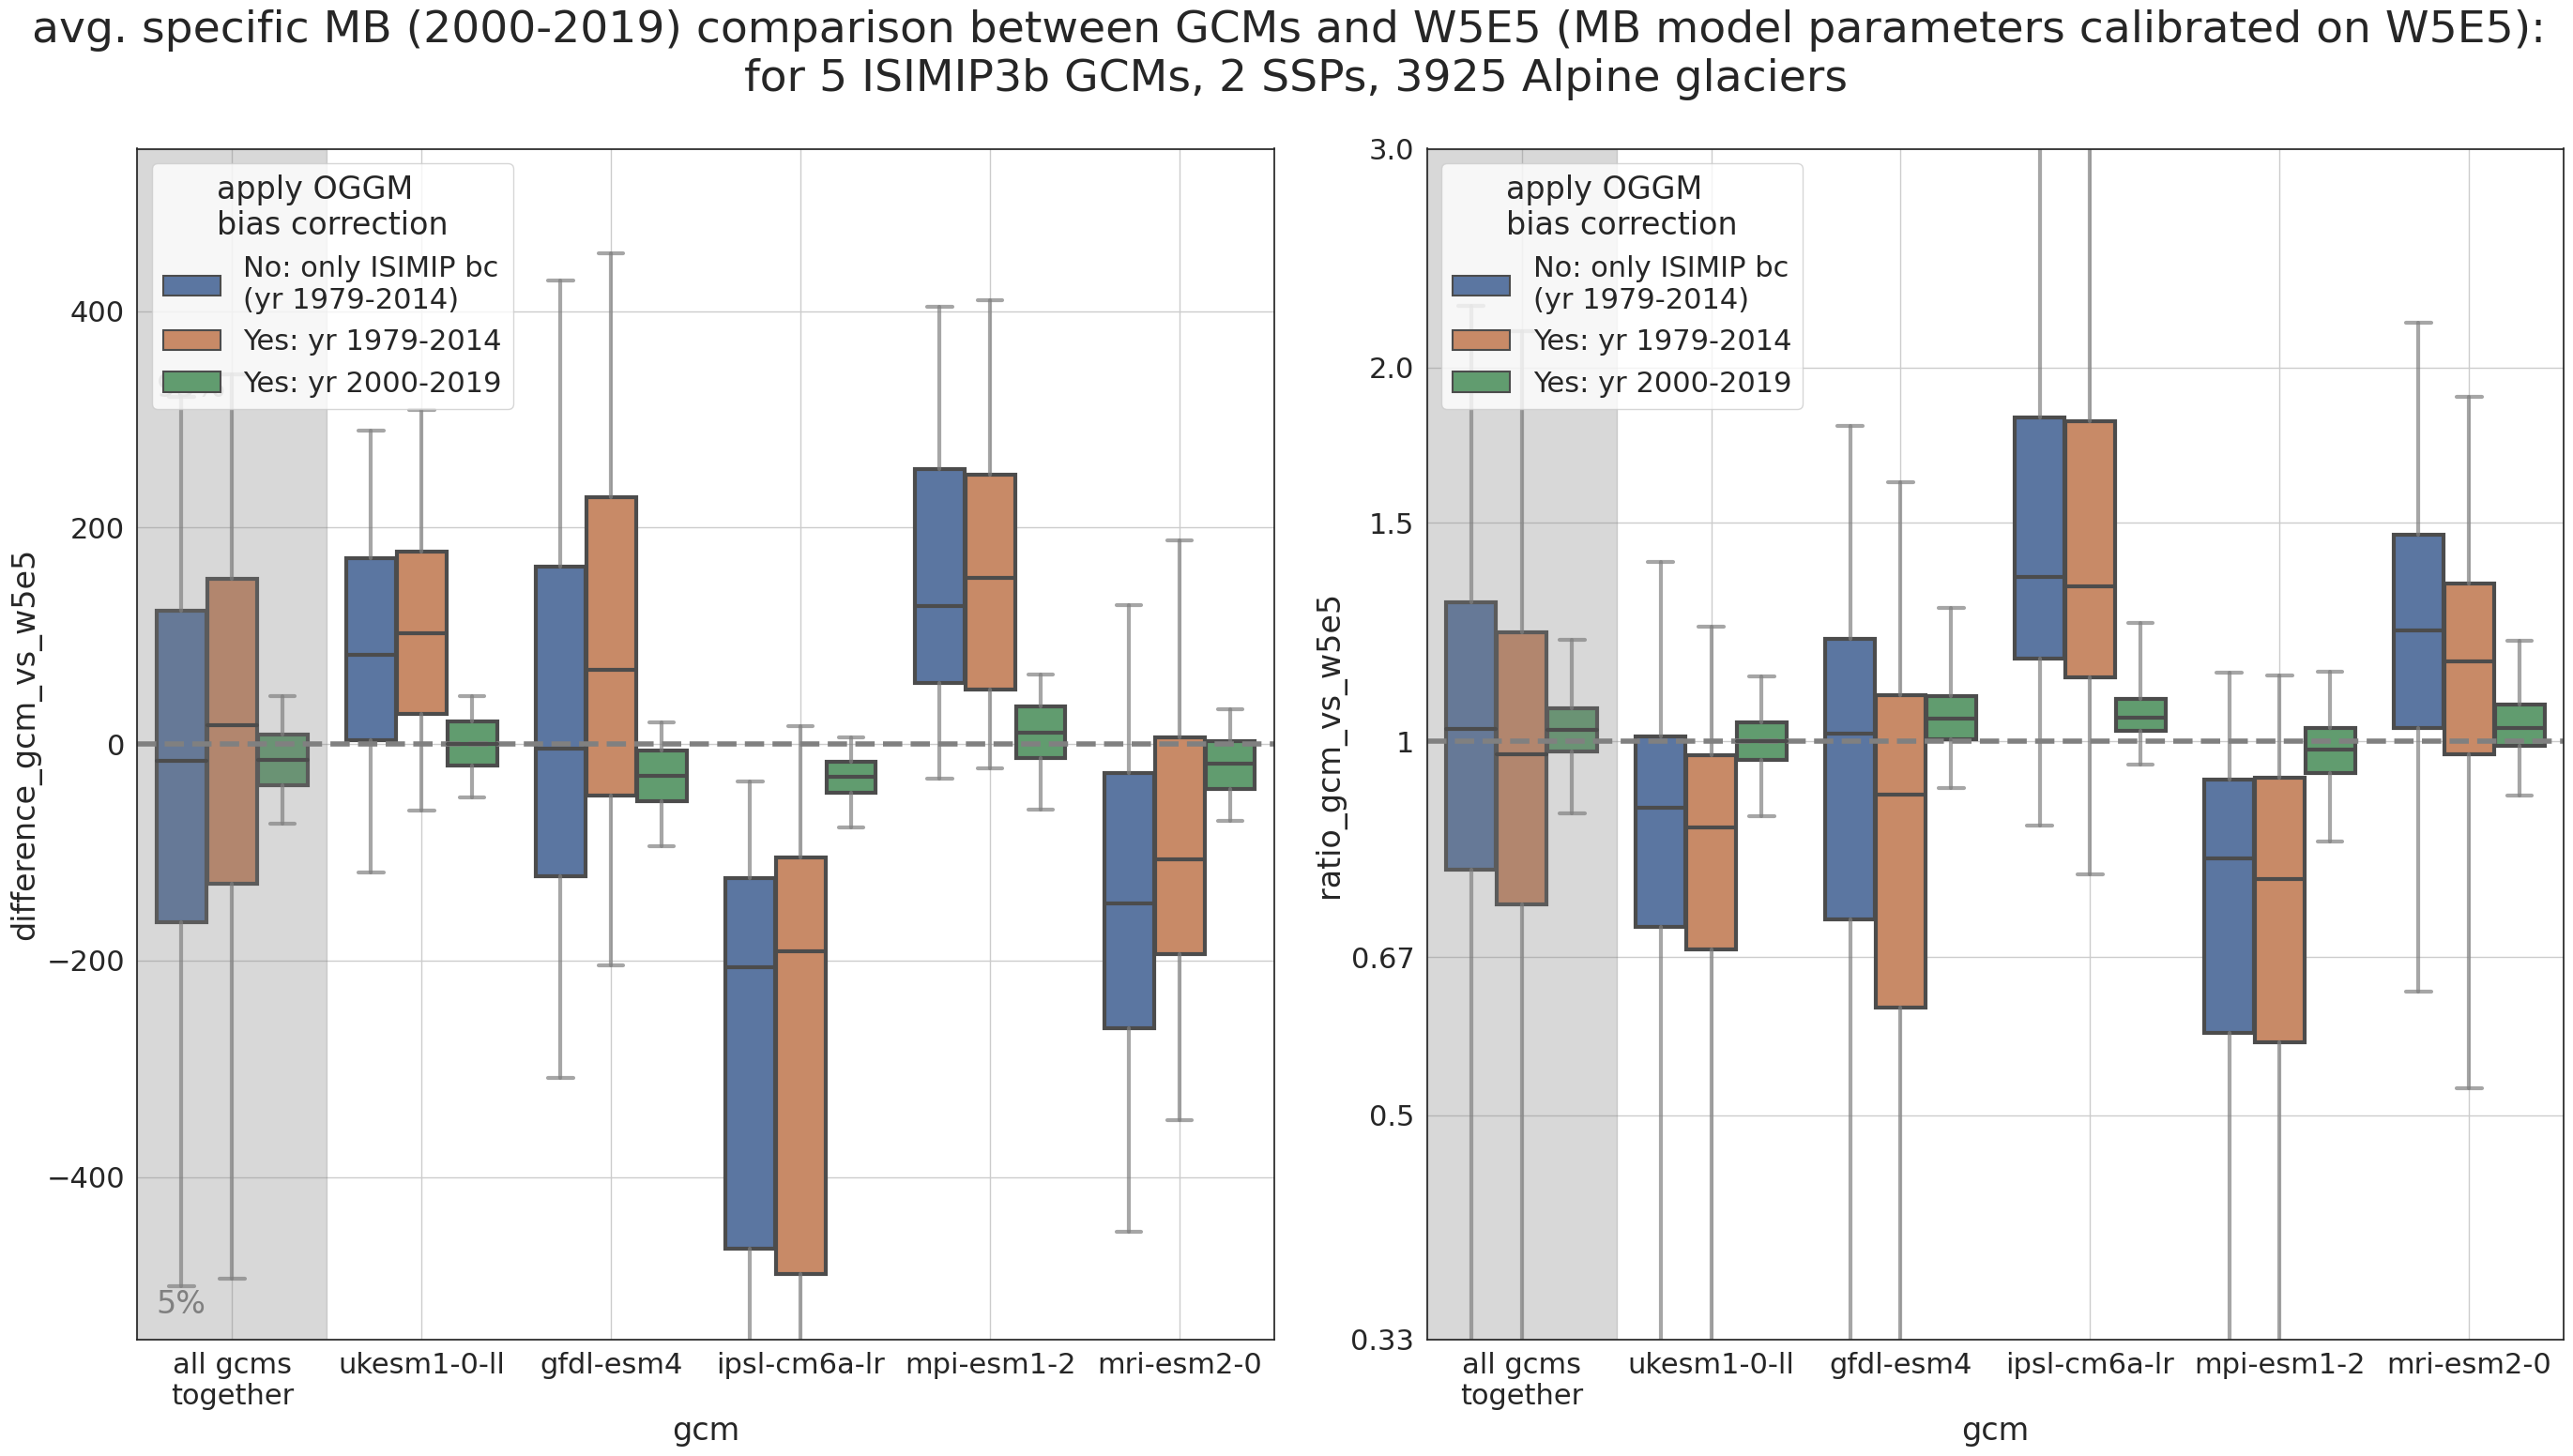

In [187]:
import seaborn as sns
n_glac = len(pd_spec_mb_gcm_vs_w5e5.rgi_id.unique())
sns.set(font_scale=2)
sns.set_style('white')
marker = 'o'


fig, axs = plt.subplots(1, 2, sharex=True, #sharey=True,
                            figsize=(28,16)) # 30, 15

plt.suptitle(f'avg. specific MB (2000-2019) comparison between GCMs and W5E5 (MB model parameters calibrated on W5E5):\n for {len(gcms)} ISIMIP3b GCMs, {len(ssps)} SSPs, {n_glac} Alpine glaciers',
             fontsize=34)

order_bc = ['No: only ISIMIP bc\n(yr 1979-2014)', 'Yes: yr 1979-2014', 'Yes: yr 2000-2019']

param = 'difference_gcm_vs_w5e5' #''difference_gcm_vs_w5e5'
axs[0].axvspan(-0.5, 0.5, alpha = 0.3, color='grey')
g=sns.boxplot(y=param, data=pd_spec_mb_gcm_vs_w5e5_all, #hue='gcm',
              hue='apply_bias_correction',
              hue_order = order_bc,
              x='gcm_sh',
              order = np.concatenate([['all gcms\ntogether'], gcms_sh]),
              fliersize=0, whis = [5,95], 
            linewidth=3,
            saturation=0.7,# aspect=1.6, #order = ['var_an_cycle'],
            capprops={'color':'grey', 'alpha':0.7},
            whiskerprops={'color':'grey', 'alpha':0.7},
              ax = axs[0]
             )
axs[0].grid()
plt.axhline(0, ls='--', lw=4, color='grey')
plt.ylabel(param)
axs[0].axhline(0, ls='--', lw=4, color='grey')
g.set_ylim([-550,550])
g.legend(loc='upper left', title = 'apply OGGM\nbias correction')
axs[0].set_xlabel('gcm')
axs[0].text(-0.4, qs.loc[(False,0.05)]*1.05, '5%', color = 'grey')
axs[0].text(-0.4, qs.loc[(False,0.95)], '95%', color = 'grey')


ax = axs[1]
param = 'ratio_gcm_vs_w5e5' #''difference_gcm_vs_w5e5'
ax.axvspan(-0.5, 0.5, alpha = 0.3, color='grey')
g=sns.boxplot(y=param, data=pd_spec_mb_gcm_vs_w5e5_all, #hue='gcm',
              hue='apply_bias_correction',
              hue_order = order_bc,
              x='gcm_sh',
              order= np.concatenate([['all gcms\ntogether'], gcms_sh]),
              fliersize=0, whis = [5,95], 
            linewidth=3,
            saturation=0.7,# aspect=1.6, #order = ['var_an_cycle'],
            capprops={'color':'grey', 'alpha':0.7},
            whiskerprops={'color':'grey', 'alpha':0.7},
              ax = ax )
g.legend(loc='upper left', title = 'apply OGGM\nbias correction')

ax.set_yscale("log")
from matplotlib.ticker import ScalarFormatter, NullFormatter
ax.yaxis.set_major_formatter(ScalarFormatter())
ax.yaxis.set_minor_formatter(NullFormatter())
ax.axhline(1, ls='--', lw=4, color='grey')
ax.set_yticklabels([])
ax.set_xlabel('gcm')
# ERROR
#  ax.set_xticklabels([0.33, 0.5, 0.67, 1,1.5, 2.0, 3.0], labels=[0.33, 0.5, 0.67, 1,1.5, 2.0, 3.0])
ax.set_yticks(ticks=[0.05,0.1,0.2,0.25,0.33, 0.5, 0.67, 1,1.5, 2.0, 3.0,4,5,10,20],
              labels=[0.05, 0.1,0.2,0.25,0.33, 0.5, 0.67, 1,1.5, 2.0, 3.0,4,5,10,20])
ax.set_ylim([0.33,3])
ax.grid() #axis='y')
plt.axhline(0, ls='--', lw=4, color='grey')
plt.ylabel(param)

plt.tight_layout()
#g.set_xlabel('surface type distinction')
#g.set_xticklabels(['no', 'yes\n(neg_exp)' , 'yes\n(linear)'])
#g.set_title(calib_type)

In [112]:
qs = pd_spec_mb_gcm_vs_w5e5.groupby(by='apply_bias_correction').quantile([0.05, 0.25,0.50,0.75, 0.95])['difference_gcm_vs_w5e5']

/tmp/ipykernel_1875130/1532525709.py:1: FutureWarning: Dropping invalid columns in DataFrameGroupBy.quantile is deprecated. In a future version, a TypeError will be raised. Before calling .quantile, select only columns which should be valid for the function.
  qs = pd_spec_mb_gcm_vs_w5e5.groupby(by='apply_bias_correction').quantile([0.05, 0.25,0.50,0.75, 0.95])['difference_gcm_vs_w5e5']


Text(0.5, -501.31565140926125, '5%')

ValueError: Image size of 601x185694 pixels is too large. It must be less than 2^16 in each direction.

<Figure size 640x480 with 1 Axes>

In [ ]:
import seaborn as sns
n_glac = len(pd_spec_mb_gcm_vs_w5e5.rgi_id.unique())
sns.set(font_scale=1.8)
sns.set_style('white')


fig, axs = plt.subplots(1, 1, sharex=True, #sharey=True,
                            figsize=(20,18)) # 30, 15

param = 'ratio_gcm_vs_w5e5' #''difference_gcm_vs_w5e5'
marker = 'o'
g=sns.boxplot(y=param, data=pd_spec_mb_gcm_vs_w5e5, #hue='gcm',
              x='apply_bias_correction',
              order=[False, True],
              fliersize=0, whis = [5,95], 
            linewidth=3,
            saturation=0.7,# aspect=1.6, #order = ['var_an_cycle'],
            capprops={'color':'grey', 'alpha':0.7},
            whiskerprops={'color':'grey', 'alpha':0.7}
             )
plt.grid()
plt.axhline(0, ls='--', lw=4, color='grey')
plt.ylabel('avg. specific MB (2000-2019) relative difference:\n'+r'100 * $\frac{specMB_{GCM} - specMB_{W5E5}}{specMB_{W5E5}}$')
plt.title('for these options: {len(gcms)} gcms, {len(ssps)} ssps, {n_glac} Alpine glaciers')

g.set_ylim([0.3,3])
g.set_yscale('log')

#g.set_xlabel('surface type distinction')
#g.set_xticklabels(['no', 'yes\n(neg_exp)' , 'yes\n(linear)'])
#g.set_title(calib_type)

Text(0.5, 1.0, 'for these options: {len(gcms)} gcms, {len(ssps)} ssps, {n_glac} Alpine glaciers')

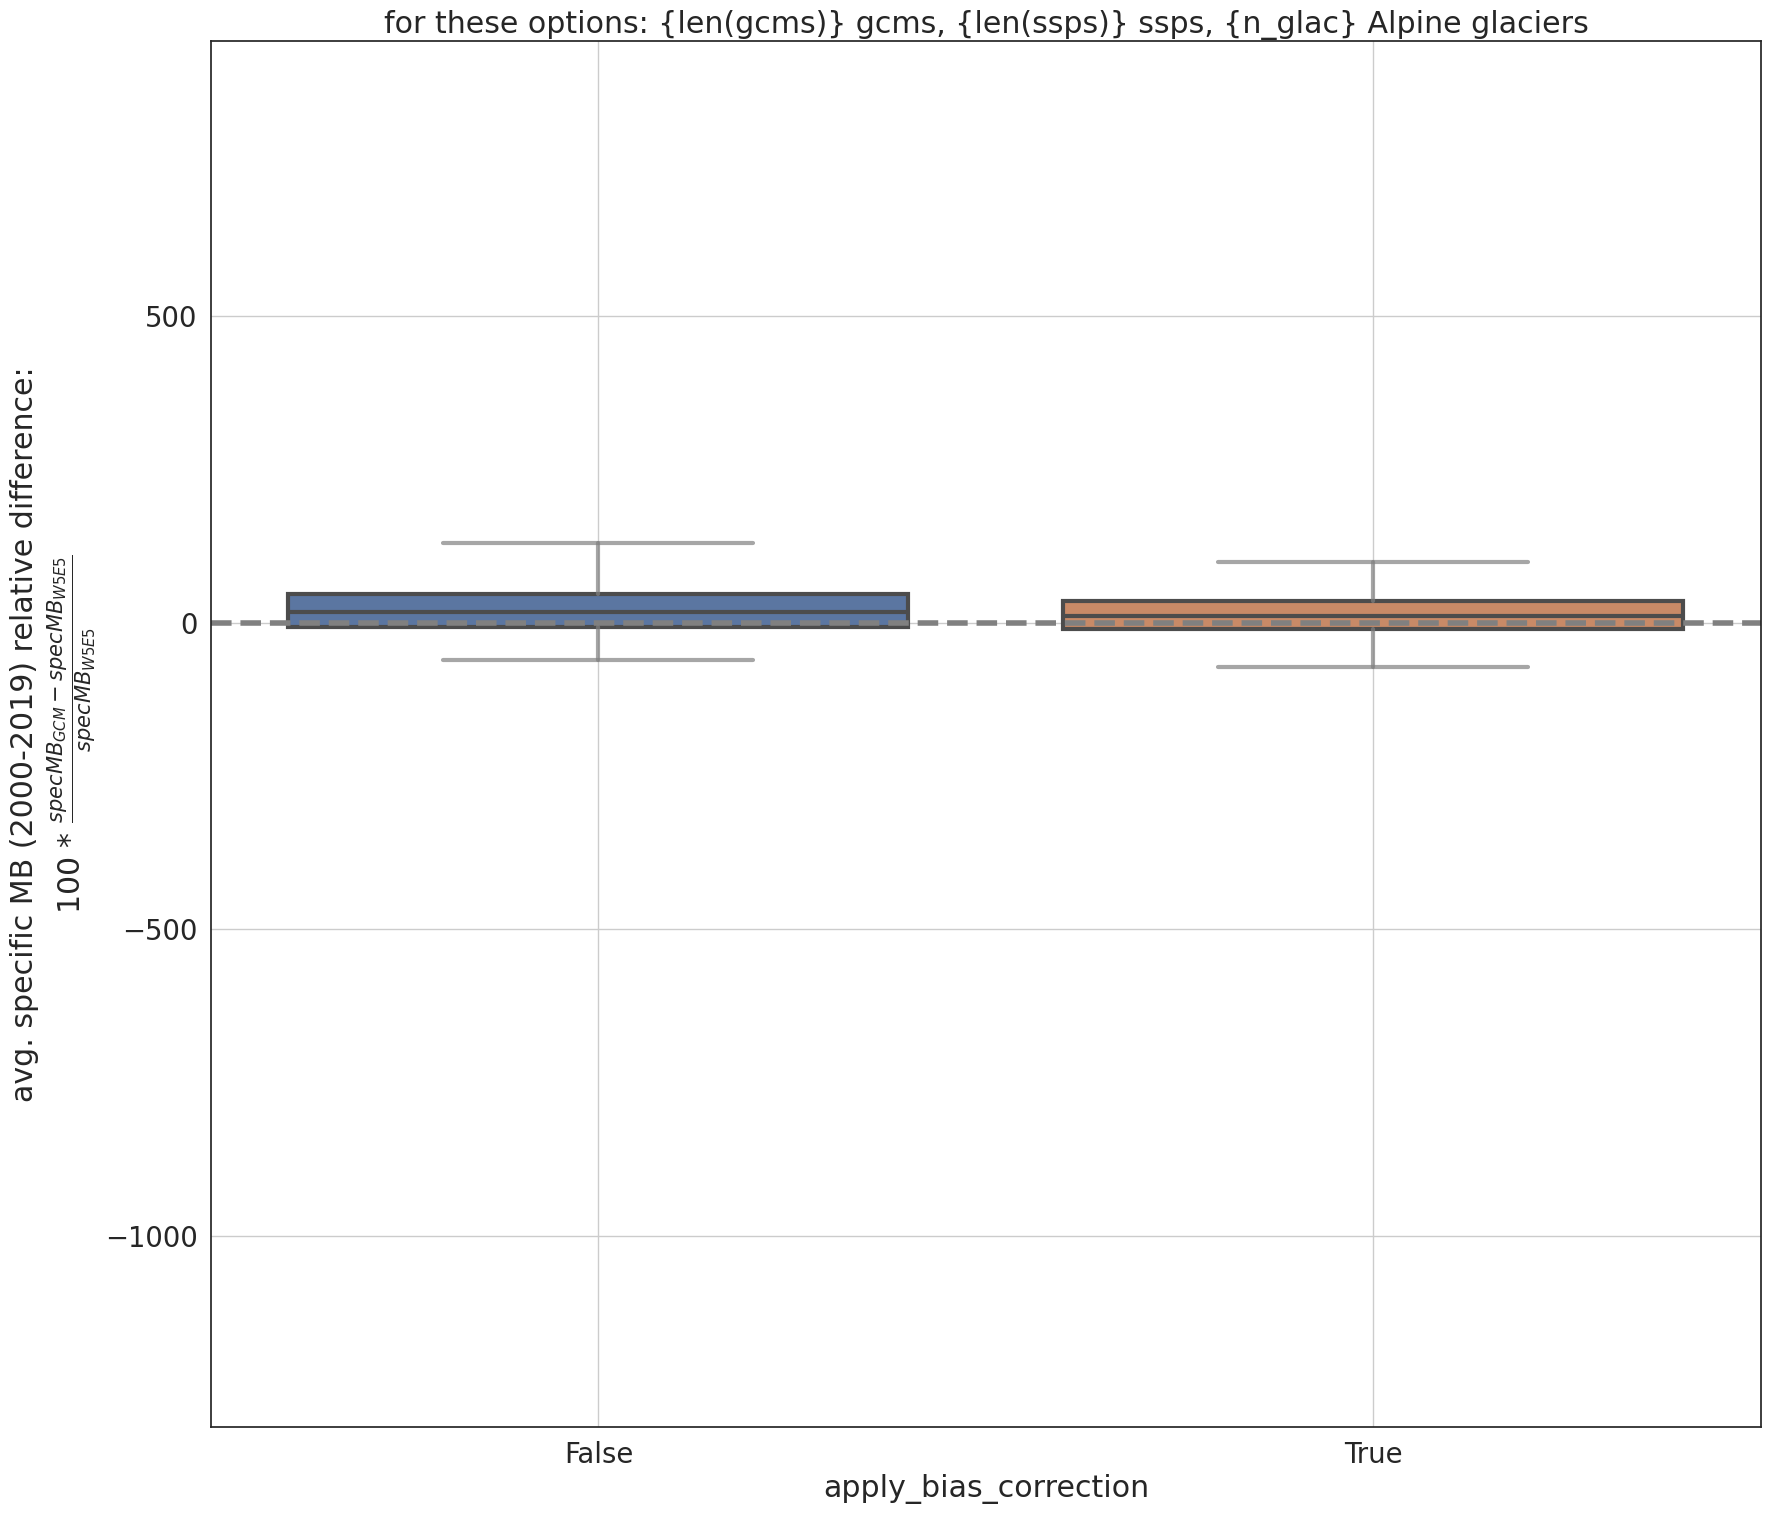

In [6]:
import seaborn as sns
n_glac = len(pd_spec_mb_gcm_vs_w5e5.rgi_id.unique())
sns.set(font_scale=1.8)
sns.set_style('white')


fig, axs = plt.subplots(1, 1, sharex=True, #sharey=True,
                            figsize=(20,18)) # 30, 15

param = 'rel_perc_difference_gcm_vs_w5e5' #''difference_gcm_vs_w5e5'
marker = 'o'
g=sns.boxplot(y=param, data=pd_spec_mb_gcm_vs_w5e5, #hue='gcm',
              x='apply_bias_correction',
              order=[False, True],
              fliersize=0, whis = [5,95], 
            linewidth=3,
            saturation=0.7,# aspect=1.6, #order = ['var_an_cycle'],
            capprops={'color':'grey', 'alpha':0.7},
            whiskerprops={'color':'grey', 'alpha':0.7}
             )
plt.grid()
plt.axhline(0, ls='--', lw=4, color='grey')
plt.ylabel('avg. specific MB (2000-2019) relative difference:\n'+r'100 * $\frac{specMB_{GCM} - specMB_{W5E5}}{specMB_{W5E5}}$')
plt.title('for these options: {len(gcms)} gcms, {len(ssps)} ssps, {n_glac} Alpine glaciers')

g.set_ylim([-100,100])

#g.set_xlabel('surface type distinction')
#g.set_xticklabels(['no', 'yes\n(neg_exp)' , 'yes\n(linear)'])
#g.set_title(calib_type)

(-700.0, 700.0)

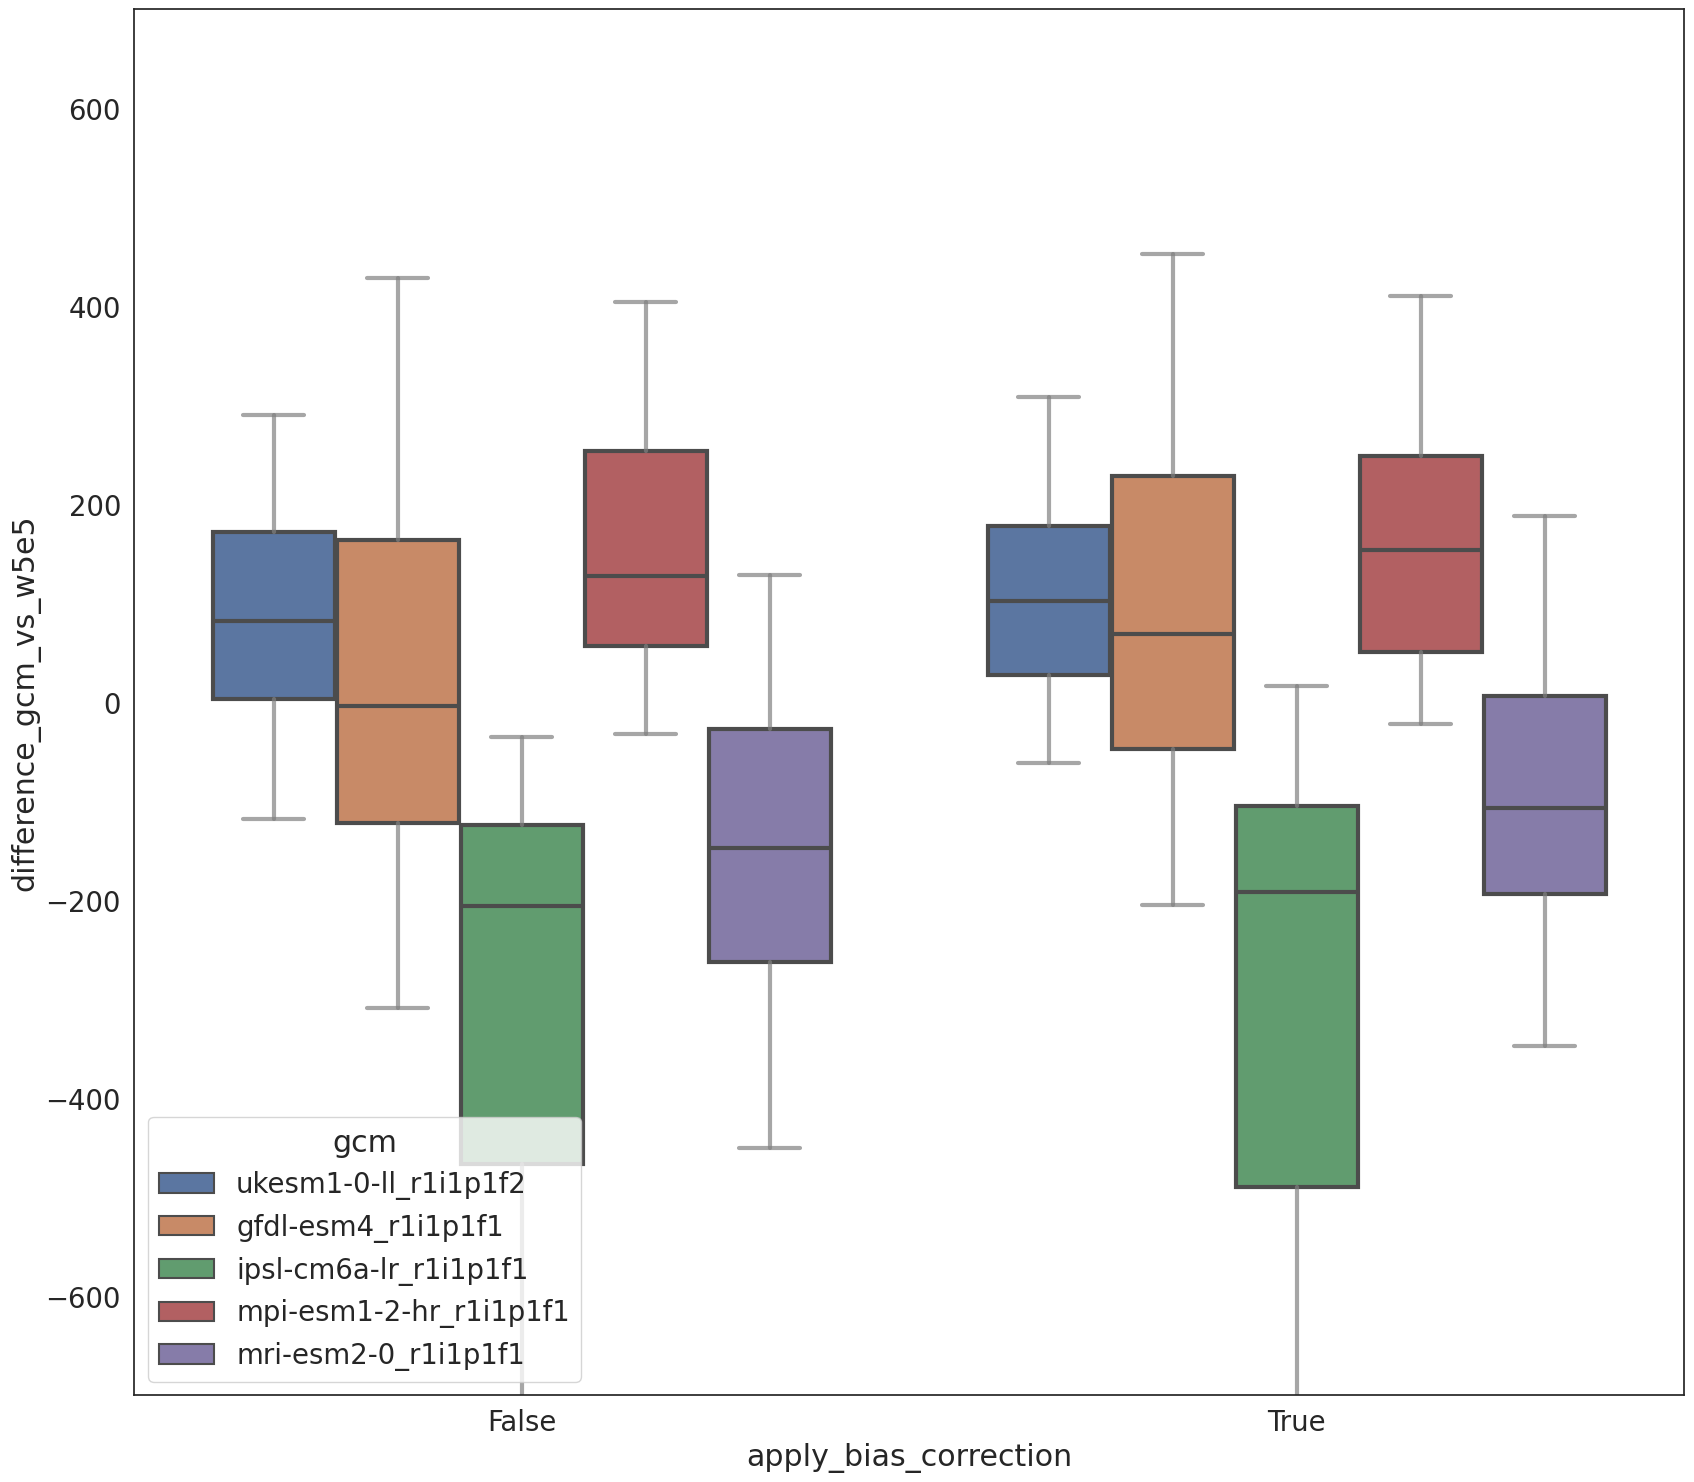

In [48]:
sns.set(font_scale=1.8)
sns.set_style('white')

col_pal = sns.color_palette(['green','lightgreen','blue','lightblue','red', 'orange'])

fig, axs = plt.subplots(1, 1, sharex=True, #sharey=True,
                            figsize=(20,18)) # 30, 15

param = 'difference_gcm_vs_w5e5' #''difference_gcm_vs_w5e5'
marker = 'o'
g=sns.boxplot(y=param, data=pd_spec_mb_gcm_vs_w5e5, hue='gcm',
              x='apply_bias_correction',
              order=[False, True],
              fliersize=0, whis = [5,95], 
            linewidth=3,
            saturation=0.7,# aspect=1.6, #order = ['var_an_cycle'],
            capprops={'color':'grey', 'alpha':0.7},
            whiskerprops={'color':'grey', 'alpha':0.7}
             )
g.set_ylim([-700,700])

#g.set_xlabel('surface type distinction')
#g.set_xticklabels(['no', 'yes\n(neg_exp)' , 'yes\n(linear)'])
#g.set_title(calib_type)